In [1]:
from collections import defaultdict

import math

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

Научимся отделять предложения на естественном языке от икусственных.

In [2]:
df_train = pd.read_csv("/content/train.tsv", sep='\t')
df_test = pd.read_csv("/content/task.tsv", sep='\t')

In [3]:
print("Read ", df_train.shape, df_test.shape)

Read  (15119, 2) (7048, 3)


In [4]:
df_train.head()

,id,text
0,0,старый запустить палаццо с высокий лепной плаф...
1,1,на угол он встретить спешить ночное извозчик
2,2,он стоялый держаться рука за перевязь швейцар ...
3,3,если разбирать она черта она несмотря на болез...
4,4,я считать что для я обязанность отправляться н...


**Основные формулы семинара**

Сглаживание по Лапласу

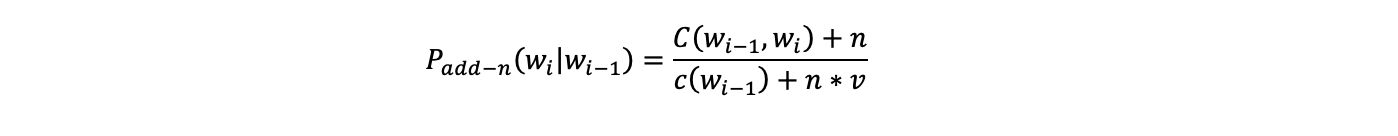

Перплексия модели

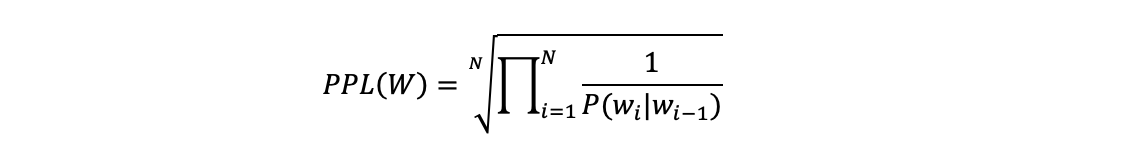

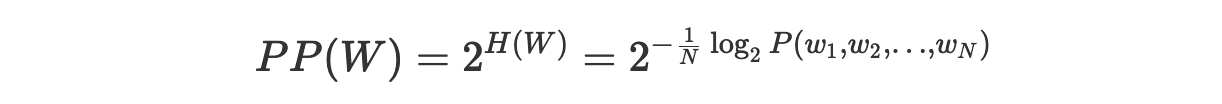

Напишем нашу первую языковую модель.

In [31]:
from nltk import bigrams


class LanguageModel(object):
    """
    Реализуйте n-граммную модель со сглаживанием Лапласа
    """

    def __init__(self, ngram_size=2, alpha=1):

        if ngram_size < 2:
            raise Exception

        self.ngram_size = ngram_size

        self.bigram_vectorizer = CountVectorizer(token_pattern='(\\S+)', ngram_range=(ngram_size, ngram_size))
        self.context_vectorizer = CountVectorizer(token_pattern='(\\S+)', ngram_range=(ngram_size - 1, ngram_size - 1))
        self.ngram_counts = defaultdict(lambda: 0)
        self.unigram_counts = defaultdict(lambda: 0)
        self.words_set_size = None

        self.alpha = alpha

    def fit(self, sentences):
        """
        Обучение модели на тексте, разбитом на предложения
        :param sentences: список предложений
        """

        print("Fitting sentences")

        counts_matrix = self.bigram_vectorizer.fit_transform(sentences)
        counts_context_matrix = self.context_vectorizer.fit_transform(sentences)
        self.words_set_size = len(
            set([key for bigram in self.bigram_vectorizer.vocabulary_.keys() for key in bigram.split()])
        )

        print("Summing...")

        sum_ngram = np.sum(counts_matrix, axis=0).A1
        sum_context = np.sum(counts_context_matrix, axis=0).A1

        print("shapes: ", sum_ngram.shape, sum_context.shape)
        print("Iterating through ngrams...")

        V = self.words_set_size
        for ngram in self.bigram_vectorizer.vocabulary_:
            context = ' '.join(ngram.split()[:-1]) # context = ngram.split()[0]
            bigram_total = sum_ngram[self.bigram_vectorizer.vocabulary_[ngram]]
            context_total = sum_context[self.context_vectorizer.vocabulary_[context]]

            self.unigram_counts[context] = np.log2(1 / (context_total + (V * self.alpha)))

            prob = (bigram_total + self.alpha) / (context_total + (V * self.alpha))
            self.ngram_counts[ngram] = np.log2(prob)

        self.ngram_counts.default_factory = lambda: np.log2( self.alpha / (V * self.alpha) )
        return self

    def perplexity(self):
        """
        Напишите функцию, вычисляющую perplexity полученной модели
        :return значение float
        """
        V = self.words_set_size
        return math.pow(2, (-1/V) * sum(self.ngram_counts.values()))

    def __log_prob_sentence(self, sentence):
        """
        Оцениваем логарифм вероятности предложения частотами в рамках данной модели
        :param sentence:
        :return: логарифм вероятности
        """
        sum_log = 1.0

        for ngram in bigrams(sentence.split()):
          bigram = ' '.join(ngram)
          if bigram in self.ngram_counts:
              sum_log += self.ngram_counts[bigram]
          elif bigram.split()[0] in self.unigram_counts:
              sum_log += self.unigram_counts[bigram.split()[0]]
          else:
              sum_log += self.ngram_counts['<UNK>']

        return sum_log

    def log_prob(self, sentence_list):
        """
        Логарифм вероятности каждого из предложений в списке
        """
        return list(map(lambda x: self.__log_prob_sentence(x), sentence_list))

Обучим получившуюся модель

In [7]:
sentences_train = df_train["text"].tolist()
sentences_train = [' '.join(['^', sentence, '$']) for sentence in sentences_train]

In [32]:
basic_lm = LanguageModel()

In [33]:
basic_lm.fit(sentences=sentences_train)

Fitting sentences
Summing...
shapes:  (117870,) (12781,)
Iterating through ngrams...


In [34]:
basic_lm.perplexity()

4.195349915012236e+34

Запустим на тесте

In [14]:
df_test.head()

,id,text1,text2
0,0,играть перед уже в лужок горелка скосить после...,после чай стать по скосить уже лужок перед дом...
1,1,— крикнуть старуха на стоять в дверь,на стоять — старуха крикнуть в дверь
2,2,женщина миловидный женщина румяный — голубой д...,три шить женщина быть федосья — феничек как он...
3,3,председатель быть удивлённый тем что присяжный...,не умысел что « » два лишить оговорить жизнь н...
4,4,да надо тут в суд узнать где жить фанарин или ...,тут суд где в надо микишина фанарин » или жить...


In [15]:
test1, test2 = df_test["text1"], df_test["text2"]

In [35]:
logprob1, logprob2 = np.array(basic_lm.log_prob(test1)), np.array(basic_lm.log_prob(test2))

In [36]:
logprob1[0], logprob2[0]

(-144.96434704210736, -141.2890943332662)

In [18]:
int(logprob1[0] > logprob2[0])

0

In [37]:
df_pred = pd.DataFrame()
df_pred["id"] = df_test["id"]
df_pred["which"] = 0
df_pred.loc[logprob2 >= logprob1, ["which"]] = 1

Возьмём разметку первых 100 примеров и протестируем на ней получившуюся модель 

In [38]:
df_true = pd.read_csv("markup.csv", sep=',')
df_pred = df_pred.head(101)

In [39]:
def compute_lm_accuracy(y_true, y_pred):
  accur = np.array([y_true == y_pred], dtype=int)
  print(float(np.sum(accur) / 101))

In [40]:
compute_lm_accuracy(df_true['which'], df_pred['which'])

0.9306930693069307


Попробуем применить любое другое значение $\alpha$ в обучении модели

In [41]:
another_lm = LanguageModel(alpha=0.05)

In [42]:
another_lm.fit(sentences=sentences_train)

Fitting sentences
Summing...
shapes:  (117870,) (12781,)
Iterating through ngrams...


In [43]:
another_lm.perplexity()

9.078430401874258e+26

In [44]:
another_lm.perplexity() < basic_lm.perplexity()

True

In [45]:
logprob1, logprob2 = np.array(another_lm.log_prob(test1)), np.array(another_lm.log_prob(test2))

In [46]:
df_pred = pd.DataFrame()
df_pred["id"] = df_test["id"]
df_pred["which"] = 0
df_pred.loc[logprob2 >= logprob1, ["which"]] = 1

In [47]:
df_pred = df_pred.head(101)

In [48]:
compute_lm_accuracy(df_true['which'], df_pred['which'])

0.9306930693069307
